# Thermodynamics Notebook

The van der Waals Equation of State is given by
$$
P = \frac{RT}{v - b} - \frac{a}{v^2}
$$

We can write it in a cubic equation form:
$$
v^3 - \left( b + \frac{RT}{P} \right) v^2 + \frac{a}{P}v - \frac{ab}{P} = 0
$$

where we need to find the roots of $v$. Or we could use the compressibility factor $Z = \frac{Pv}{RT}$ and solve the following

$$
Z^3 - \frac{P}{RT} \left( b + \frac{RT}{P} \right) Z^2 + \frac{P}{RT}^2 \frac{a}{P}Z - \frac{ab}{P} \frac{P}{RT}^3 = 0
$$

$$
A = \frac{aP}{(RT)^2}
$$

$$
B = \frac{bP}{RT}
$$

$$
Z^3 - \left( B + 1 \right) Z^2 +  AZ - AB = 0
$$

The fugacity is given by

$$
\ln \phi_i = \ln \frac{f_i}{x_i P} = \frac{1}{RT} \int_{V}^{\infty} \left( \frac{\partial P}{\partial N_i} - \frac{RT}{V}\right) dV - \ln Z
$$

$$
\ln f_i = \ln \left( \frac{y_i}{v - b} \right) + \frac{b_i}{v-b} - \frac{2 \sum_j y_j a_{ij}}{vRT}
$$

Or in terms of $Z$:

$$
\ln \frac{f_i}{y_i P} = \frac{B_i}{Z-B} -\ln \left( Z - B \right) - \frac{2 \sum_j y_j A_{ij}}{Z}
$$

The block of code below represent some auxiliary methods. The `find_correct_root_of_cubic_eos(...)` method calculated the correct cubic root (smallest root for liquid and largest root for vapor).

In [1]:
# %load utils.py
import numpy as np
from math import sqrt, acos, cos


def calculate_K_values_wilson(P, T, Pc, Tc, ω):
    return (Pc / P) * np.exp(5.37 * (1 + ω) * (1 - (Tc / T)))


def calculate_roots_of_cubic_equation(p0, p1, p2, p3):
    coef_a = (3.0 * p2 - (p1 ** 2)) / 3.0
    coef_b = (2.0 * (p1 ** 3) - 9.0 * p1 * p2 + 27.0 * p3) / 27.0
    delta = 0.25 * (coef_b ** 2) + (coef_a ** 3) / 27.0

    roots = []
    if delta > 0.0:
        # 1 real root, 2 imaginary
        const_A = np.cbrt(-0.5 * coef_b + sqrt(delta))
        const_B = np.cbrt(-0.5 * coef_b - sqrt(delta))

        single_root = const_A + const_B - p1 / 3.0

        roots.append(single_root)
    else:
        # 3 real roots
        phi = acos(-0.5 * coef_b / sqrt(-(coef_a ** 3) / 27.0))
        root_1 = 2.0 * sqrt(-coef_a / 3.0) * cos(phi / 3.0) - p1 / 3.0
        root_2 = 2.0 * sqrt(-coef_a / 3.0) * cos(phi / 3.0 + 2.0 * np.pi / 3.0) - p1 / 3.0
        root_3 = 2.0 * sqrt(-coef_a / 3.0) * cos(phi / 3.0 + 4.0 * np.pi / 3.0) - p1 / 3.0

        roots.append(root_1)
        roots.append(root_2)
        roots.append(root_3)

    return roots

In [2]:
# %load eos.py
import numpy as np

from utils import calculate_roots_of_cubic_equation

R = 8.314  # [kg/(J.K)]
SQRT_2 = np.sqrt(2)


def find_correct_root_of_cubic_eos(p0, p1, p2, p3, fluid_type):
    roots = calculate_roots_of_cubic_equation(p0, p1, p2, p3)
    if len(roots) > 1:
        assert len(roots) == 3, 'Size of roots has to be 1 or 3!'

        roots.sort()
        if fluid_type is 'liquid':
            correct_root = roots[0]  # smallest
        else:
            assert fluid_type is 'vapor', 'Wrong fluid type! ' + fluid_type
            correct_root = roots[2]  # largest
    else:
        correct_root = roots[0]

    assert correct_root > 0.0, fluid_type + ' Z-factor < 0.0! %f' % correct_root

    return correct_root


class EquationOfState:
    def __init__(
        self,
        Pc, 
        Tc,
        ω,
        Ω_a,
        Ω_b,
        κ_ij
    ):
        self.Pc   = Pc
        self.Tc   = Tc
        self.ω    = ω
        self.Ω_a  = Ω_a
        self.Ω_b  = Ω_b
        self.κ_ij = κ_ij

    def α_function(self, T, Tc, ω):
        raise NotImplementedError("This function has not been implemented for this class!")

    def update_eos_coefficients(self, P, T, x):
        κ_ij = self.κ_ij

        α = self.α_function(T, self.Tc, self.ω)

        self.a = (self.Ω_a * α * (R * self.Tc) ** 2) / self.Pc
        self.b = (self.Ω_b * R * self.Tc) / self.Pc
        self.a *= P / (R * T) ** 2
        self.b *= P / (R * T)
        
        A_ij = (1.0 - κ_ij) * np.sqrt(np.einsum('i,j', self.a, self.a))

        # This variables will be used in the fugacity expression
        self.A_ij_x_j = np.einsum('ij,j', A_ij, x)
        
        self.a_mix = np.dot(np.dot(x, A_ij), x)
        self.b_mix = np.sum(x * self.b)
        
    def calculate_normalized_gibbs_energy(self, f, x):
        g = (x * np.log(f)).sum()
        return g
    
    def calculate_fugacities_with_minimum_gibbs_energy(self, P, T, x):
        # TODO: Work in progress, calculate fugacities by 
        # calculating all roots and if it has two possible roots
        # calculate both minimim gibbs energy and choose the 
        # group of fugacities with minimum gibbs energy

        self.update_eos_coefficients(P, T, x)

        Z = self.calculate_eos_roots()

        f0 = self.calculate_fugacities(P, T, Z[0], x)

        if len(Z) == 1:
            return f0

        if Z[1] < 0.0:
            return f0

        f1 = self.calculate_fugacities(P, T, Z[1], x)

        g0 = self.calculate_normalized_gibbs_energy(f0, x)
        g1 = self.calculate_normalized_gibbs_energy(f1, x)

        if g0 < g1:
            return f0
        else:
            return f1


class VanDerWaalsEos(EquationOfState):
    def α_function(self, T, Tc, ω):
        return 1.0

    def calculate_eos_roots(self, fluid_type=None):
        A_mix = self.a_mix
        B_mix = self.b_mix

        p0 = 1.0
        p1 = - (B_mix + 1.0)
        p2 = A_mix
        p3 = - A_mix * B_mix

        if fluid_type is None:
            return calculate_roots_of_cubic_equation(p0, p1, p2, p3)
        else:
            return find_correct_root_of_cubic_eos(p0, p1, p2, p3, fluid_type)

    def calculate_fugacities(self, P, T, Z, x):
        ln_f = self.b / (Z - self.b_mix) - np.log(Z - self.b_mix) - 2.0 * self.A_ij_x_j / Z

        return (x * P) * np.exp(ln_f)  # [Pa]


class PengRobinsonEos(EquationOfState):
    def α_function(self, T, Tc, ω):
        m = np.where(
            ω < 0.49,
            0.374640 + 1.54226 * ω - 0.269920 * (ω ** 2),
            0.379642 + 1.48503 * ω - 0.164423 * (ω ** 2) + 0.016667 * (ω ** 3)
        )
        return (1.0 + m * (1.0 - np.sqrt(T / Tc))) ** 2

    def calculate_eos_roots(self, fluid_type=None):
        A_mix = self.a_mix
        B_mix = self.b_mix

        p0 = 1.0
        p1 = - (1.0 - B_mix)
        p2 = A_mix - 3.0 * (B_mix ** 2) - 2.0 * B_mix
        p3 = -(A_mix * B_mix - B_mix ** 2 - B_mix ** 3)

        if fluid_type is None:
            return calculate_roots_of_cubic_equation(p0, p1, p2, p3)
        else:
            return find_correct_root_of_cubic_eos(p0, p1, p2, p3, fluid_type)

    def calculate_fugacities(self, P, T, Z, x):

        ln_f = (self.b / self.b_mix) * (Z - 1.0) - np.log(Z - self.b_mix) \
               + (self.a_mix / (2.0 * SQRT_2 * self.b_mix)) \
                 * ((self.b / self.b_mix) - 2.0 * self.A_ij_x_j / self.a_mix) \
                 * np.log((Z + (1.0 + SQRT_2) * self.b_mix) / (Z + (1.0 - SQRT_2) * self.b_mix))

        return (x * P) * np.exp(ln_f)  # [Pa]


class SoaveRedlichKwongEos(EquationOfState):
    def α_function(self, T, Tc, ω):
        m = 0.480 + 1.574 * ω - 0.176 * (ω ** 2)
        return (1.0 + m * (1.0 - np.sqrt(T / Tc))) ** 2

    def calculate_eos_roots(self, fluid_type=None):
        A_mix = self.a_mix
        B_mix = self.b_mix

        p0 = 1.0
        p1 = -1.0
        p2 = A_mix - B_mix - (B_mix ** 2)
        p3 = -(A_mix * B_mix)

        if fluid_type is None:
            return calculate_roots_of_cubic_equation(p0, p1, p2, p3)
        else:
            return find_correct_root_of_cubic_eos(p0, p1, p2, p3, fluid_type)

    def calculate_fugacities(self, P, T, Z, x):
        ln_f = (self.b / self.b_mix) * (Z - 1.0) - np.log(Z - self.b_mix) \
               + (self.a_mix / self.b_mix) \
                 * ((self.b / self.b_mix) - 2.0 * self.A_ij_x_j / self.a_mix) \
                 * np.log(1.0 + (self.b_mix / Z))

        return (x * P) * np.exp(ln_f)  # [Pa]


In [3]:
# %load rachford_rice.py
import numpy as np
from scipy.optimize import brentq, newton, bisect


def func_rachford_rice(x, z, K_values):
    '''
    x = n_moles_gas / n_moles_total
    '''
    c = 1.0 / (K_values - 1.0)
    return np.sum(z / (c + x))


def deriv_rachford_rice(x, z, K_values):
    c = 1.0 / (K_values - 1.0)
    return - np.sum(z / ((c + x) ** 2))


def calculate_rachford_rice(z, K_values):
    min_K = np.min(K_values)
    max_K = np.max(K_values)

    min_val = 0.999 / (1.0 - max_K)
    max_val = 0.999 / (1.0 - min_K)

    F_V = brentq(func_rachford_rice, min_val, max_val, args=(z, K_values))
    # F_V = newton(func=func_rachford_rice, x0=0.5, fprime=deriv_rachford_rice, args=(z, K_values))
    # F_V = bisect(func_rachford_rice, min_val, max_val, args=(z, K_values))

    return F_V

In [4]:
# %load flash.py
import numpy as np

from rachford_rice import calculate_rachford_rice


def flash_residual_function(x, T, P, eos, z):
    size = x.shape[0]

    # Get values from unknown vector
    K = x[0:size - 1]  # K-values
    F_V = x[size - 1]

    if F_V < 0.0:
        F_V = 0.0
    if F_V > 1.0:
        F_V = 1.0

    x_L = z / (F_V * (K - 1) + 1)
    x_V = K * x_L

    # Vapor
    f_V = eos.calculate_fugacities_with_minimum_gibbs_energy(P, T, x_V)

    # Liquid
    f_L = eos.calculate_fugacities_with_minimum_gibbs_energy(P, T, x_L)

    residual_fugacity = f_L - f_V
    residual_mass = np.sum(z * (K - 1) / (1 + F_V * (K - 1)))
    residual = np.r_[residual_fugacity, residual_mass]

    return residual


def ss_flash(
        eos,
        P,
        T,
        z,
        K_values_initial,
        max_iter=50,
        tolerance=1.0e-3,
        print_statistics=False
):
    K = np.copy(K_values_initial)

    # Initialize error with some value
    error = 100.0

    counter = 0
    while error > tolerance and counter < max_iter:
        F_V = calculate_rachford_rice(z, K)
        x_L = z / (F_V * (K - 1) + 1)
        x_V = K * x_L

        # Vapor
        f_V = eos.calculate_fugacities_with_minimum_gibbs_energy(P, T, x_V)

        # Liquid
        f_L = eos.calculate_fugacities_with_minimum_gibbs_energy(P, T, x_L)

        f_ratio = f_L / f_V
        K *= f_ratio

        error = np.linalg.norm(f_ratio - 1)
        counter += 1

    if print_statistics:
        print('SS Flash: %d iterations, error is %g.' % (counter, error))

    return K, F_V, f_L

In [5]:
# %load stability.py
import numpy as np


def stability_test_residual_function(x, T, P, eos, z, test_type):
    # Getting unknowns
    u = x

    # ref
    f_ref = eos.calculate_fugacities_with_minimum_gibbs_energy(P, T, z)

    if test_type is 'vapor':
        other_type = 'liquid'
        K_values = u / z
        x_u = z * K_values

    else:
        assert test_type is 'liquid', 'Non existing test_type! ' + test_type
        other_type = 'vapor'
        K_values = z / u
        x_u = z / K_values

    x_u_normalized = x_u / np.sum(x_u)

    # Liquid
    f_u = eos.calculate_fugacities_with_minimum_gibbs_energy(P, T, x_u_normalized)

    residual = f_ref - f_u * np.sum(x_u)

    return residual

def ss_stability_test(
        eos,
        P,
        T,
        z,
        test_type,
        K_values_initial,
        max_iter=100,
        tolerance=1.0e-5
):
    K = np.copy(K_values_initial)

    error = 100.0

    f_ref = eos.calculate_fugacities_with_minimum_gibbs_energy(P, T, z)

    counter = 0
    while error > tolerance and counter < max_iter:
        if test_type is 'vapor':
            other_type = 'liquid'
            x_u = z * K
        else:
            assert test_type is 'liquid', 'Non existing test_type! ' + test_type
            other_type = 'vapor'
            x_u = z / K

        sum_x_u = np.sum(x_u)
        x_u_normalized = x_u / sum_x_u

        f_u = eos.calculate_fugacities_with_minimum_gibbs_energy(P, T, x_u_normalized)

        if test_type is 'vapor':
            correction = f_ref / (f_u * sum_x_u)
        else:
            assert test_type is 'liquid', 'Non existing test_type! ' + test_type
            correction = (f_u * sum_x_u) / f_ref

        K *= correction
        error = np.linalg.norm(correction - 1.0)
        counter += 1

    return sum_x_u, K

def calculate_stability_test(
        eos,
        P,
        T,
        z,
        K_values_initial
):
    sum_vapor, K_values_vapor = ss_stability_test(
        eos,
        P,
        T,
        z,
        'vapor',
        K_values_initial
    )

    sum_liquid, K_values_liquid = ss_stability_test(
        eos,
        P,
        T,
        z,
        'liquid',
        K_values_initial
    )

    sum_ln_K_vapor = np.linalg.norm(np.log(K_values_vapor)) ** 2
    sum_ln_K_liquid = np.linalg.norm(np.log(K_values_liquid)) ** 2
    sum_tol = 1.0e-8

    # Table 4.6 from Phase Equilibria
    if sum_ln_K_vapor < 1.0e-4 and sum_ln_K_liquid < 1.0e-4:
        is_stable = True
    elif (sum_vapor - 1.0) <= sum_tol and sum_ln_K_liquid < 1.0e-4:
        is_stable = True
    elif (sum_liquid - 1.0) <= sum_tol and sum_ln_K_vapor < 1.0e-4:
        is_stable = True
    elif (sum_vapor - 1.0) <= sum_tol and (sum_liquid - 1.0) <= sum_tol:
        is_stable = True
    elif (sum_vapor - 1.0) > sum_tol and sum_ln_K_liquid < 1.0e-4:
        is_stable = False
    elif (sum_liquid - 1.0) > sum_tol and sum_ln_K_vapor < 1.0e-4:
        is_stable = False
    elif (sum_vapor - 1.0) > sum_tol and (sum_liquid - 1.0) > sum_tol:
        is_stable = False
    elif (sum_vapor - 1.0) > sum_tol and (sum_liquid - 1.0) <= sum_tol:
        is_stable = False
    elif (sum_vapor - 1.0) <= sum_tol and (sum_liquid - 1.0) > sum_tol:
        is_stable = False
    else:
        assert False, 'ERROR: No stability condition found...'

    if not is_stable:
        K_values_estimates = K_values_vapor * K_values_liquid
    else:
        K_values_estimates = np.copy(K_values_initial)

    return is_stable, K_values_estimates

# Input Data

In [6]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [7]:
def input_properties_case_7_psudocomponents():
    '''
    7 pseudo-components
    
    '''
    
    temperature = 366.5
    pressure = 150.0 * 1.0e5

    critical_pressure = 101325.0 * np.array([45.45, 51.29, 39.89, 31.95, 27.91, 17.71, 12.52]) # [atm]
    critical_temperature = np.array([189.2, 305.4, 395.8, 485.1, 592.0, 697.1, 804.4]) # [K]
    acentric_factor = np.array([0.00891, 0.11352, 0.17113, 0.26910, 0.34196, 0.51730, 0.72755]) # [-]
    molar_mass = 0.001 * np.array([16.38, 31.77, 50.64, 77.78, 118.44, 193.95, 295.30]) # [g/mol]
    omega_a = np.array([0.344772, 0.521974, 0.514972, 0.419169, 0.485943, 0.570583, 0.457236]) # [-]
    omega_b = np.array([0.063282, 0.099825, 0.107479, 0.093455, 0.07486, 0.101206, 0.077796]) # [-]

    binary_interaction = np.array(
    [[ 0.000000,  0.000622, -0.002471,  0.011418, -0.028367, -0.100000, 0.206868],
     [ 0.000622,  0.000000, -0.001540,  0.010046,  0.010046,  0.010046, 0.010046],
     [-0.002471, -0.001540,  0.000000,  0.002246,  0.002246,  0.002246, 0.002246],
     [ 0.011418,  0.010046,  0.002246,  0.000000,  0.000000,  0.000000, 0.000000],
     [-0.028367,  0.010046,  0.002246,  0.000000,  0.000000,  0.000000, 0.000000],
     [-0.100000,  0.010046,  0.002246,  0.000000,  0.000000,  0.000000, 0.000000],
     [ 0.206868,  0.010046,  0.002246,  0.000000,  0.000000,  0.000000, 0.000000]]
    )

    global_molar_fractions = np.array([0.6793, 0.099, 0.1108, 0.045, 0.05011, 0.0134, 0.00239])
    
    return (pressure, temperature, global_molar_fractions, 
            critical_pressure, critical_temperature, acentric_factor,
            molar_mass, omega_a, omega_b, binary_interaction)

In [8]:
def input_properties_case_whitson_problem_18_PR():
    '''
    TEST PROBLEM PHASE BEHAVIOUR WHITSON PROBLEM 18 APPENDIX
    
    Methane, Butane and Decane (C1, C4 and C10).
    
    Properties for the Van der Waals Equation of State.
    
    '''
    temperature = (280.0 + 459.67) * 5.0 / 9.0
    pressure = 500.0 * 6894.75729

    critical_pressure = 6894.75729 * np.array([667.8, 550.7, 304.0]) # [atm]
    critical_temperature = (5.0 / 9.0) * np.array([343.0, 765.3, 1111.8]) # [K]
    acentric_factor = np.array([0.011500, 0.192800, 0.490200]) # [-]
    molar_mass = 0.001 * np.array([16.04, 58.12, 142.29]) # [g/mol]
    omega_a = 0.45724 * np.array([1.0, 1.0, 1.0]) # [-]
    omega_b = 0.07780 * np.array([1.0, 1.0, 1.0]) # [-]

    binary_interaction = np.array(
    [[0.000000,  0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000]]
    )

    global_molar_fractions = np.array([0.5, 0.42, 0.08])

    return (pressure, temperature, global_molar_fractions, 
        critical_pressure, critical_temperature, acentric_factor,
        molar_mass, omega_a, omega_b, binary_interaction)
    
fugacity_expected = np.array([294.397, 148.342, 3.02385]) * 6894.75729
K_values_expected = np.array([6.65071, 0.890061, 0.03624])
x_expected = np.array([0.08588, 0.46349, 0.45064])
y_expected = np.array([0.57114, 0.41253, 0.01633])

In [9]:
def input_properties_case_whitson_problem_18_VDW():
    '''
    TEST PROBLEM PHASE BEHAVIOUR WHITSON PROBLEM 18 APPENDIX
     
    Methane, Butane and Decane (C1, C4 and C10).
    
    Properties for the Van der Waals Equation of State.
    
    '''
    temperature = (280.0 + 459.67) * 5.0 / 9.0
    pressure = 500.0 * 6894.75729

    critical_pressure = 6894.75729 * np.array([667.8, 550.7, 304.0]) # [atm]
    critical_temperature = (5.0 / 9.0) * np.array([343.0, 765.3, 1111.8]) # [K]
    acentric_factor = np.array([0.011500, 0.192800, 0.490200]) # [-]
    molar_mass = 0.001 * np.array([16.04, 58.12, 142.29]) # [g/mol]
    omega_a = (27.0 / 64.0) * np.array([1.0, 1.0, 1.0]) # [-]
    omega_b = (1.0 / 8.0) * np.array([1.0, 1.0, 1.0]) # [-]

    binary_interaction = np.array(
    [[0.000000,  0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000]]
    )

    global_molar_fractions = np.array([0.5, 0.42, 0.08])

    return (pressure, temperature, global_molar_fractions, 
        critical_pressure, critical_temperature, acentric_factor,
        molar_mass, omega_a, omega_b, binary_interaction)


In [10]:
def input_properties_case_whitson_problem_18_SRK():
    '''
    TEST PROBLEM PHASE BEHAVIOUR WHITSON PROBLEM 18 APPENDIX
    
    Methane, Butane and Decane (C1, C4 and C10).
    
    Properties for the Soave-Redlich-Kwong Equation of State.
    
    '''
    temperature = (280.0 + 459.67) * 5.0 / 9.0
    pressure = 500.0 * 6894.75729

    critical_pressure = 6894.75729 * np.array([667.8, 550.7, 304.0]) # [atm]
    critical_temperature = (5.0 / 9.0) * np.array([343.0, 765.3, 1111.8]) # [K]
    acentric_factor = np.array([0.011500, 0.192800, 0.490200]) # [-]
    molar_mass = 0.001 * np.array([16.04, 58.12, 142.29]) # [g/mol]
    omega_a = 0.42748 * np.array([1.0, 1.0, 1.0]) # [-]
    omega_b = 0.08664 * np.array([1.0, 1.0, 1.0]) # [-]

    binary_interaction = np.array(
    [[0.000000,  0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000]]
    )

    global_molar_fractions = np.array([0.5, 0.42, 0.08])

    return (pressure, temperature, global_molar_fractions, 
        critical_pressure, critical_temperature, acentric_factor,
        molar_mass, omega_a, omega_b, binary_interaction)

In [11]:
def input_properties_case_dissertation_PR():
    '''
    TEST PROBLEM PHASE BEHAVIOUR DISSERTATION
    
    Methane, Ethane, Butane and Heptane (pseudo) (C1, C2, C4 and C7).
    
    Properties for the Peng-Robinson Equation of State.
    
    '''
    temperature = np.nan
    pressure = np.nan

    critical_pressure = 101325.0 * np.array([45.40, 48.20, 37.50, 30.97]) # [atm]
    critical_temperature = np.array([190.6, 305.4, 425.2, 543.2]) # [K]
    acentric_factor = np.array([0.008, 0.098, 0.193, 0.308]) # [-]
    molar_mass = 0.001 * np.array([16.04, 30.07, 58.12, 96.00]) # [g/mol]
    omega_a = 0.45724 * np.array([1.0, 1.0, 1.0, 1.0]) # [-]
    omega_b = 0.07780 * np.array([1.0, 1.0, 1.0, 1.0]) # [-]

    binary_interaction = np.array(
    [[0.000000,  0.000000, 0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000, 0.000000]]
    )

    global_molar_fractions = np.array([0.1, 0.4, 0.4, 0.1])

    return (pressure, temperature, global_molar_fractions, 
        critical_pressure, critical_temperature, acentric_factor,
        molar_mass, omega_a, omega_b, binary_interaction)

# Validation

In [12]:
# Get input properties
#props = input_properties_case_7_psudocomponents()
props = input_properties_case_whitson_problem_18_PR()
#props = input_properties_case_whitson_problem_18_SRK()
#props = input_properties_case_whitson_problem_18_VDW()

(pressure, temperature, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props

#temperature = 350.0 # [K]
#pressure = 50.0 * 1e5 # [Pa]

# Estimate initial K-values
initial_K_values = calculate_K_values_wilson(
    pressure,
    temperature,
    critical_pressure,
    critical_temperature,
    acentric_factor
)

# Create EoS object and set properties
#eos = VanDerWaalsEos, PengRobinsonEos, SoaveRedlichKwongEos
eos = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)

is_stable, K_values_est = calculate_stability_test(
    eos,
    pressure, 
    temperature, 
    global_molar_fractions,
    initial_K_values
)

print ('System is stable?', is_stable)
print ('K_values estimates:', K_values_est)

K_values_from_ss_flash, F_V, f_L = ss_flash(eos, pressure, temperature, global_molar_fractions, K_values_est, tolerance = 1.0e-1)
print ('K_values Successive Subst:', K_values_from_ss_flash)
print ('Vapor molar fraction:', F_V)
print ('\n-----\nFugacities obtained:', f_L)
print ('Fugacities expected:', fugacity_expected)

# Use estimates from Wilson's Equation!!!
#x0 = np.append(initial_K_values, F_V) # It does not work!

# Use estimates from stability test!!!
#x0 = np.append(K_values_est, F_V) # It does not work!

# Use estimates from successive substitutions!!!
x0 = np.append(K_values_from_ss_flash, F_V) # Good estimate!

result = fsolve(
    func=flash_residual_function,
    x0=x0,
    args=(temperature, pressure, eos, global_molar_fractions),
)

size = result.shape[0]
K_values_newton = result[0:size-1]
F_V = result[size-1]
print ('K_values newton:', K_values_newton)
print ('K_values expected:', K_values_expected)
print ('Norm difference:', np.linalg.norm(K_values_expected - K_values_newton))
print ('Vapor molar fraction:', F_V)

System is stable? False
K_values estimates: [ 6.95845633  0.97032417  0.04632674]
K_values Successive Subst: [ 6.66717534  0.8915857   0.03631528]
Vapor molar fraction: 0.8564956477304408

-----
Fugacities obtained: [ 2006928.05285734  1013950.01555535    21078.58593721]
Fugacities expected: [ 2029795.86190413  1022782.08591318    20848.71183137]
K_values newton: [ 6.65190636  0.89020925  0.03623162]
K_values expected: [ 6.65071   0.890061  0.03624 ]
Norm difference: 0.00120554190043
Vapor molar fraction: 0.853426828702


The methods below will be used for generating vapor fraction curves

In [13]:
# %load equilibrium.py
import numpy as np
from scipy.optimize import fsolve

from flash import ss_flash, flash_residual_function
from stability import calculate_stability_test


def calculate_vapor_liquid_equilibrium(
        eos,
        P,
        T,
        z,
        K_values_estimates,
        print_statistics=False
):
    size = z.shape[0]

    is_stable, K_values_est = calculate_stability_test(
        eos,
        P,
        T,
        z,
        K_values_estimates
    )

    if not is_stable:
        K_values_from_ss_flash, F_V, f_L = ss_flash(eos, P, T,
                                                    z, K_values_est,
                                                    tolerance=1.0e-5,
                                                    print_statistics=print_statistics)

        x0 = np.append(K_values_from_ss_flash, F_V)
        result, infodict, ier, mesg = fsolve(
            func=flash_residual_function,
            x0=x0,
            args=(T, P, eos, z),
            full_output=True,
        )

        if print_statistics:
            print('Newton flash converged? %d, %s' % (ier, mesg))

        K_values = result[0:size]
        F_V = result[size]
    else:
        if P < 50.0e5:
            F_V = 1.0
        else:
            F_V = 0.0

        K_values = np.ones(size)

    return F_V, K_values


def calculate_molar_fraction_curve(
        eos, pressure_points, T, z,
        print_statistics=False
):
    size = z.shape[0]
    res = []
    K_values = np.ones(size)

    for iteration, P in enumerate(pressure_points):
        if np.linalg.norm(K_values - 1.0) < 1.0e-3:
            # Estimate initial K-values
            K_values_estimates = calculate_K_values_wilson(P, T, eos.Pc, eos.Tc, eos.ω)
        else:
            K_values_estimates = np.copy(K_values)

        if print_statistics:
            print('Pressure: %g bar' % (P / 1.0e5))
        F_V, K_values = calculate_vapor_liquid_equilibrium(
            eos, P, T, z,
            K_values_estimates, print_statistics)
        # print P/1.0e5, F_V

        res.append(F_V)

    return np.array(res)

# Calculate Vapor and Liquid Curves

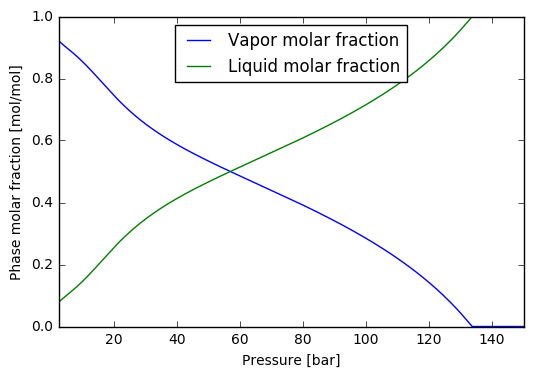

In [14]:
temperature = 350.0 # [K]
pressure = np.linspace(2.5, 150.0, num=200) * 1.0e5 # [Pa]

# Create EoS object and set properties
props = input_properties_case_whitson_problem_18_PR()
(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props
eos_pr = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)

result = calculate_molar_fraction_curve(eos, pressure, temperature, global_molar_fractions)


pressure_bar = pressure / 1.0e5
plt.plot(pressure_bar, result, label='Vapor molar fraction')
plt.plot(pressure_bar, 1.0-result, label='Liquid molar fraction')
plt.xlabel('Pressure [bar]')
plt.ylabel('Phase molar fraction [mol/mol]')
plt.legend(loc='upper center')
plt.axis([np.min(pressure_bar), np.max(pressure_bar), 0.0, 1.0])
plt.show()

# Comparisons of Different Equation of State

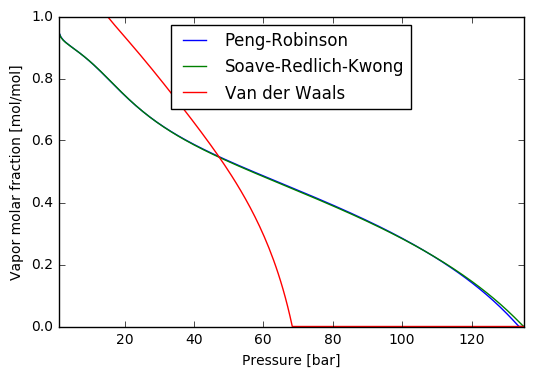

In [15]:
# PENG-ROBINSON
props = input_properties_case_whitson_problem_18_PR()
(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props
eos_pr = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)
# SOAVE-REDLICH-KWONG
props = input_properties_case_whitson_problem_18_SRK()
(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props
eos_srk = SoaveRedlichKwongEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)
# VAN DER WAALS
props = input_properties_case_whitson_problem_18_VDW()
(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props
eos_vdw = VanDerWaalsEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)

temperature = 350.0 # [K]
pressure = np.linspace(1, 135.0, num=200) * 1.0e5 # [Pa]
result_pr = calculate_molar_fraction_curve(eos_pr, pressure, temperature, global_molar_fractions)
result_srk = calculate_molar_fraction_curve(eos_srk, pressure, temperature, global_molar_fractions)
result_vdw = calculate_molar_fraction_curve(eos_vdw, pressure, temperature, global_molar_fractions)

pressure_bar = pressure / 1.0e5
plt.plot(pressure_bar, result_pr, label='Peng-Robinson')
plt.plot(pressure_bar, result_srk, label='Soave-Redlich-Kwong')
plt.plot(pressure_bar, result_vdw, label='Van der Waals')
plt.xlabel('Pressure [bar]')
plt.ylabel('Vapor molar fraction [mol/mol]')
plt.legend(loc='upper center')
plt.axis([np.min(pressure_bar), np.max(pressure_bar), 0.0, 1.0])
plt.show()

# Retrograde Condensation

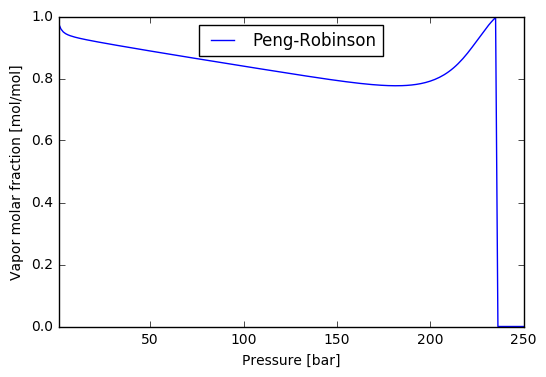

In [16]:
# PENG-ROBINSON
props = input_properties_case_7_psudocomponents()
(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props
eos_pr = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)

temperature = 350.0 # [K]
pressure = np.linspace(1.0, 250.0, num=200) * 1.0e5 # [Pa]
result_pr = calculate_molar_fraction_curve(eos_pr, pressure, temperature, global_molar_fractions)

pressure_bar = pressure / 1.0e5
plt.plot(pressure_bar, result_pr, label='Peng-Robinson')

plt.xlabel('Pressure [bar]')
plt.ylabel('Vapor molar fraction [mol/mol]')
plt.legend(loc='upper center')
plt.axis([np.min(pressure_bar), np.max(pressure_bar), 0.0, 1.0])
plt.show()

# Near critical point

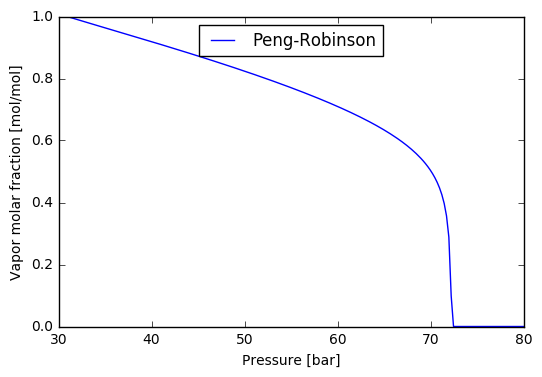

In [17]:
# PENG-ROBINSON
props = input_properties_case_dissertation_PR()
(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props
eos_pr = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)

#temperature = 366.5 # [K] Easy ss flash converges
temperature = 408.0 # [K] Hard, number of iter reached!
pressure = np.linspace(30.0, 80.0, num=200) * 1.0e5 # [Pa]
result_pr = calculate_molar_fraction_curve(
    eos_pr, pressure,
    temperature, global_molar_fractions, print_statistics=False
)

pressure_bar = pressure / 1.0e5
plt.plot(pressure_bar, result_pr, label='Peng-Robinson')

plt.xlabel('Pressure [bar]')
plt.ylabel('Vapor molar fraction [mol/mol]')
plt.legend(loc='upper center')
plt.axis([np.min(pressure_bar), np.max(pressure_bar), 0.0, 1.0])
plt.show()

In [18]:
def input_properties_case_Ghafri(T, filename='comp.xlsx'):
    pressure, temperature = np.nan, np.nan

    import pandas as pd
    data_comp = pd.read_excel(io=filename, sheetname='Components', header=3)
    data_bib = pd.read_excel(io=filename, sheetname='BIP\'s', header=6)
    data_z = pd.read_excel(io=filename, sheetname='Live Oil Composition', header=6)    

    component_names = data_comp['Name'].iloc[:-2].as_matrix()
    component_formula = data_comp['Formula'].iloc[:-2].as_matrix()
    critical_pressure = data_comp['Pc (bar) - \nCritical Pressure'].iloc[:-2].as_matrix() * 1e5 # [Pa]
    critical_temperature = data_comp['Tc (K) - \nCritical Temperature'].iloc[:-2].as_matrix() # [K]
    acentric_factor = data_comp['ω (-) - \nPitzer\'s Acentric Factor'].iloc[:-2].as_matrix() # [-]
    molar_mass = data_comp['Mw (kg/mol) - \nMolar Weight'].iloc[:-2].as_matrix() # [kg/mol]
    omega_a = np.full_like(molar_mass, 0.45724) # [-]
    omega_b = np.full_like(molar_mass, 0.07780) # [-]

    N = len(component_names)

    φ0 = np.zeros((N, N))
    φ1 = np.zeros((N, N))
    φ2 = np.zeros((N, N))

    for i, (name, col) in enumerate(data_bib.items()):
        φ = np.r_[i*[-1, -1, -1], [0.5, 0.5, 0.5], data_bib[name].dropna().values]
        φ = φ.reshape((N, 3))
        φ0[i:, i] = φ[i:, 0]
        φ1[i:, i] = φ[i:, 1]
        φ2[i:, i] = φ[i:, 2]

    φ0 = φ0 + φ0.T 
    φ1 = φ1 + φ1.T 
    φ2 = φ2 + φ2.T 

    def BIP(T, φ0, φ1, φ2):
        expr = φ0 + φ1 * T + φ2 * T**2
        np.fill_diagonal(expr, 1.0)
        return expr

    binary_interaction = BIP(T, φ0, φ1, φ2)

    global_molar_fractions = data_z['Unnamed: 1'].values[:-2]

    return (pressure, temperature, global_molar_fractions, 
        critical_pressure, critical_temperature, acentric_factor,
        molar_mass, omega_a, omega_b, binary_interaction)

In [42]:
# Get input properties
temperature = 290.0 # [K]
pressure = 1.0 * 1e5 # [Pa]

props = input_properties_case_Ghafri(temperature)

(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props

# Estimate initial K-values
initial_K_values = calculate_K_values_wilson(
    pressure,
    temperature,
    critical_pressure,
    critical_temperature,
    acentric_factor
)

# Create EoS object and set properties
eos = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)

is_stable, K_values_est = calculate_stability_test(
    eos,
    pressure, 
    temperature, 
    global_molar_fractions,
    initial_K_values
)

print ('System is stable?', is_stable)
print ('K_values estimates:', K_values_est)

K_values_from_ss_flash, F_V, f_L = ss_flash(eos, pressure, temperature, global_molar_fractions, K_values_est, tolerance = 1.0e-1)
print ('K_values Successive Subst:', K_values_from_ss_flash)
print ('Vapor molar fraction:', F_V)
print ('\n-----\nFugacities obtained:', f_L)


# Use estimates from Wilson's Equation!!!
#x0 = np.append(initial_K_values, 0.2) # It does not work!

# Use estimates from stability test!!!
x0 = np.append(K_values_est, 0.85) # It does not work!

# Use estimates from successive substitutions!!!
#x0 = np.append(K_values_from_ss_flash, F_V) # Good estimate!

result = fsolve(
    func=flash_residual_function,
    x0=x0,
    args=(temperature, pressure, eos, global_molar_fractions),
)

size = result.shape[0]
K_values_newton = result[0:size-1]
F_V = result[size-1]
print ('K_values newton:', K_values_newton)
print ('Vapor molar fraction:', F_V)

System is stable? False
K_values estimates: [ 0.86339344  0.89450735  0.83515706  0.79007599  0.67387378  0.61573603
  0.6004428   0.54509622  0.57088403  0.54742267  0.49071843  0.49196303
  0.42174723  0.42104338  0.36436089  0.34346015  0.30394351  0.27294528
  0.24981735  1.47969203  0.14186917]
K_values Successive Subst: [ 0.99966068  0.99970258  0.99962197  0.99955662  0.9993679   0.99925927
  0.9992322   0.99911591  0.99917356  0.99912415  0.99899115  0.99899591
  0.99881462  0.9988049   0.99863584  0.99857065  0.99841271  0.99828368
  0.99815821  1.00079402  0.99723426]
Vapor molar fraction: 266.7966882592883

-----
Fugacities obtained: [ 35388.85027294  15175.41436208   2097.38096843    928.82275406
   1431.11583549   1105.67272831    633.09463381    449.46580297
    286.09123518    408.18873323    518.90377654    295.04446517
     81.71437441    410.69455197    167.60278593     66.00826117
    184.54836811    142.10609271    156.80073725  34051.69609338
    478.3732442 ]
K_va

D:\Miniconda3\envs\petsc_debug\lib\site-packages\ipykernel\__main__.py:68: RuntimeWarning: invalid value encountered in log
D:\Miniconda3\envs\petsc_debug\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
